In [32]:
import numpy as np
from math import log, sqrt, exp, erf
from qiskit import QuantumCircuit

# Try to import Aer in a version-agnostic way
try:
    from qiskit import Aer
except ImportError:
    from qiskit_aer import Aer


# ============================================================
# 1. ANALYTIC BLACK–SCHOLES (CALL & PUT)
# ============================================================

def N(x: float) -> float:
    """Standard normal CDF using erf (no scipy needed)."""
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))


def bs_call_price(S0: float, K: float, r: float, sigma: float, T: float) -> float:
    """Analytic Black–Scholes call price."""
    if T <= 0 or sigma <= 0:
        return max(S0 - K, 0.0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S0 * N(d1) - K * exp(-r * T) * N(d2)


def bs_put_price(S0: float, K: float, r: float, sigma: float, T: float) -> float:
    """Analytic Black–Scholes put price."""
    call = bs_call_price(S0, K, r, sigma, T)
    return call - S0 + K * exp(-r * T)


# ============================================================
# 2. CLASSICAL BINOMIAL TREE (FOR COMPARISON)
# ============================================================

def binomial_call_price(S0: float, K: float, r: float, sigma: float,
                        T: float, N_steps: int) -> float:
    """
    Standard Cox-Ross-Rubinstein binomial tree for a call.
    """
    dt = T / N_steps
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    # Terminal prices
    prices = [S0 * (u ** j) * (d ** (N_steps - j)) for j in range(N_steps + 1)]
    payoffs = [max(S - K, 0.0) for S in prices]

    # Backward induction
    for step in range(N_steps - 1, -1, -1):
        payoffs = [
            disc * (p * payoffs[i + 1] + (1.0 - p) * payoffs[i])
            for i in range(step + 1)
        ]

    return payoffs[0]


def binomial_put_price(S0: float, K: float, r: float, sigma: float,
                       T: float, N_steps: int) -> float:
    """
    Binomial tree for a put.
    """
    dt = T / N_steps
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    prices = [S0 * (u ** j) * (d ** (N_steps - j)) for j in range(N_steps + 1)]
    payoffs = [max(K - S, 0.0) for S in prices]

    for step in range(N_steps - 1, -1, -1):
        payoffs = [
            disc * (p * payoffs[i + 1] + (1.0 - p) * payoffs[i])
            for i in range(step + 1)
        ]

    return payoffs[0]


# ============================================================
# 3. GLOBAL PARAMETERS FOR QRW (YOU CAN TUNE THESE)
# ============================================================

# You will tune these in experiments; start with simple ones
S0 = 1.0        # initial stock price
K = 1.0         # strike
r = 0.02        # risk-free rate
sigma = 0.2     # volatility
T = 5.0         # maturity (years)

N_steps = 5     # time-steps in walk (same role as binomial steps)

# Derived binomial quantities used both classically and in QRW mapping
delta_t = T / N_steps
u = np.exp(sigma * np.sqrt(delta_t))
d = np.exp(-sigma * np.sqrt(delta_t))
p_rn = (np.exp(r * delta_t) - d) / (u - d)   # risk-neutral probability

# Position register: nodes j = 0..N_steps
N_pos = N_steps
n_pos_qubits = int(np.ceil(np.log2(N_pos + 1)))

coin_qubit_idx = 0
pos_start_idx = 1
n_qubits = 1 + n_pos_qubits


# ============================================================
# 4. QRW BUILDING BLOCKS
# ============================================================

def set_position_state(qc: QuantumCircuit, j: int,
                       pos_start: int, n_pos: int):
    """Initialize position register in computational basis |j>."""
    # Little-endian: qubit(pos_start) = LSB
    bin_str = format(j, f"0{n_pos}b")[::-1]
    for k, bit in enumerate(bin_str):
        if bit == "1":
            qc.x(pos_start + k)


def biased_coin_gate(qc: QuantumCircuit, theta: float, coin_idx: int):
    """
    Biased coin on coin qubit: Ry(2*theta).
    Probability(|1>) = sin^2(theta) ≈ risk-neutral p.
    """
    qc.ry(2 * theta, coin_idx)


def controlled_increment_mod_2n(qc: QuantumCircuit,
                                coin_idx: int,
                                pos_start: int,
                                n_pos: int):
    """
    Controlled increment by 1 modulo 2^n_pos on the position register.
    Implemented as a standard ripple-carry increment, with the coin as
    an extra control on all gates.
    """
    # Qubits of position register
    pos_qubits = [pos_start + k for k in range(n_pos)]

    # First bit: CX(coin -> q0)
    qc.cx(coin_idx, pos_qubits[0])

    # Higher bits: MCX(coin, q0..q_{k-1} -> qk)
    for k in range(1, n_pos):
        controls = [coin_idx] + pos_qubits[:k]
        qc.mcx(controls, pos_qubits[k])


def controlled_decrement_mod_2n(qc: QuantumCircuit,
                                coin_idx: int,
                                pos_start: int,
                                n_pos: int):
    """
    Controlled decrement by 1 modulo 2^n_pos using:
        x -> NOT( INC( NOT(x) ) )
    All operations controlled on coin_idx = |1>.
    """
    pos_qubits = [pos_start + k for k in range(n_pos)]

    # NOT all position bits
    for q in pos_qubits:
        qc.x(q)

    # Controlled increment
    controlled_increment_mod_2n(qc, coin_idx, pos_start, n_pos)

    # NOT all position bits back
    for q in pos_qubits:
        qc.x(q)


def qrw_step(qc: QuantumCircuit, theta: float,
             coin_idx: int, pos_start: int, n_pos: int):
    """
    One time-step of the discrete-time quantum random walk:
      1. Biased coin
      2. If coin=1 -> increment position (move "up")
      3. If coin=0 -> decrement position (move "down")
    """
    # 1) Coin
    biased_coin_gate(qc, theta, coin_idx)

    # 2) Up move when coin = |1>
    controlled_increment_mod_2n(qc, coin_idx, pos_start, n_pos)

    # 3) Down move when coin = |0>
    qc.x(coin_idx)
    controlled_decrement_mod_2n(qc, coin_idx, pos_start, n_pos)
    qc.x(coin_idx)


def build_qrw_circuit() -> QuantumCircuit:
    """
    Build the QRW circuit that approximates the terminal distribution
    over j up-moves (0..N_steps).
    """
    qc = QuantumCircuit(n_qubits, n_pos_qubits)

    # Start in a "central" node j0 ~ N_steps // 2 (you can experiment)
    j0 = N_steps // 2
    set_position_state(qc, j0, pos_start_idx, n_pos_qubits)

    # Coin starts in |0> by default

    # Biased coin angle from risk-neutral p
    theta = float(np.arcsin(np.sqrt(p_rn)))

    # Apply N_steps QRW time-steps
    for _ in range(N_steps):
        qrw_step(qc, theta, coin_qubit_idx, pos_start_idx, n_pos_qubits)

    # Measure position register only
    for k in range(n_pos_qubits):
        qc.measure(pos_start_idx + k, k)

    return qc


# ============================================================
# 5. PRICING FROM QRW MEASUREMENTS
# ============================================================

def call_put_from_counts(counts: dict) -> (float, float):
    """
    Given measurement counts over position basis states,
    compute QRW call & put prices by mapping j -> S_j.
    """
    total_call = 0.0
    total_put = 0.0
    total_counts = 0

    for bitstring, c in counts.items():
        # bitstring: high bit = highest classical bit index
        j = int(bitstring, 2)

        # Ignore positions beyond N_steps (wrap-around artifacts)
        if j > N_steps:
            continue

        S_j = S0 * (u ** j) * (d ** (N_steps - j))
        call_payoff = max(S_j - K, 0.0)
        put_payoff = max(K - S_j, 0.0)

        total_call += call_payoff * c
        total_put += put_payoff * c
        total_counts += c

    if total_counts == 0:
        return 0.0, 0.0

    avg_call = total_call / total_counts
    avg_put = total_put / total_counts
    disc = np.exp(-r * T)

    return disc * avg_call, disc * avg_put


def qrw_call_put_price(shots: int = 8192):
    """
    Build the QRW circuit, run on qasm_simulator using backend.run
    (no execute), and return (call_price, put_price, counts).
    """
    qc = build_qrw_circuit()
    backend = Aer.get_backend("qasm_simulator")
    job = backend.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    call_qrw, put_qrw = call_put_from_counts(counts)
    return call_qrw, put_qrw, counts


# ============================================================
# 6. EXPERIMENT / DEMO: COMPARE ALL METHODS
# ============================================================

def run_single_experiment(shots: int = 4096):
    """
    Run one experiment for current global parameters.
    Prints:
      - Analytic BS call & put
      - Binomial call & put
      - QRW call & put
      - Errors
    """
    print("Parameters:")
    print(f"  S0={S0}, K={K}, r={r}, sigma={sigma}, T={T}, N_steps={N_steps}")
    print()

    # Analytic
    bs_c = bs_call_price(S0, K, r, sigma, T)
    bs_p = bs_put_price(S0, K, r, sigma, T)

    # Classical binomial
    bin_c = binomial_call_price(S0, K, r, sigma, T, N_steps)
    bin_p = binomial_put_price(S0, K, r, sigma, T, N_steps)

    # Quantum random walk
    qrw_c, qrw_p, counts = qrw_call_put_price(shots=shots)

    print("Analytic Black–Scholes:")
    print(f"  Call: {bs_c:.6f}")
    print(f"  Put : {bs_p:.6f}")
    print()

    print("Binomial tree (classical, same N_steps):")
    print(f"  Call: {bin_c:.6f}  (abs error vs analytic: {abs(bin_c - bs_c):.6f})")
    print(f"  Put : {bin_p:.6f}  (abs error vs analytic: {abs(bin_p - bs_p):.6f})")
    print()

    print("Quantum Random Walk (QRW):")
    print(f"  Call: {qrw_c:.6f}  (abs error vs analytic: {abs(qrw_c - bs_c):.6f})")
    print(f"  Put : {qrw_p:.6f}  (abs error vs analytic: {abs(qrw_p - bs_p):.6f})")
    print(f"  Shots: {shots}")
    print(f"  Raw counts: {counts}")
    print()


def sweep_steps_and_shots():
    """
    A small sweep over N_steps and shots.
    This table is GOLD for your report / slides.
    """
    global N_steps, delta_t, u, d, p_rn

    Ns = [3, 4, 5]
    shot_list = [1024, 4096, 16384]

    bs_c = bs_call_price(S0, K, r, sigma, T)

    print("Sweep: N_steps vs shots (Call price only)")
    print("N_steps | shots  | QRW_call | BS_call | abs_err")
    print("-" * 55)

    for N in Ns:
        N_steps = N
        delta_t = T / N_steps
        u = np.exp(sigma * np.sqrt(delta_t))
        d = np.exp(-sigma * np.sqrt(delta_t))
        p_rn = (np.exp(r * delta_t) - d) / (u - d)

        for shots in shot_list:
            qrw_c, _, _ = qrw_call_put_price(shots=shots)
            err = abs(qrw_c - bs_c)
            print(f"{N:7d} | {shots:6d} | {qrw_c:8.5f} | {bs_c:8.5f} | {err:8.5f}")
    print()


if __name__ == "__main__":
    # 1) Run a single detailed experiment (for the report narrative)
    run_single_experiment(shots=4096)

    # 2) Run a sweep (for a table to show in slides/paper)
    sweep_steps_and_shots()


Parameters:
  S0=1.0, K=1.0, r=0.02, sigma=0.2, T=5.0, N_steps=5

Analytic Black–Scholes:
  Call: 0.220221
  Put : 0.125058

Binomial tree (classical, same N_steps):
  Call: 0.227860  (abs error vs analytic: 0.007639)
  Put : 0.132698  (abs error vs analytic: 0.007639)

Quantum Random Walk (QRW):
  Call: 1.102500  (abs error vs analytic: 0.882280)
  Put : 0.064156  (abs error vs analytic: 0.060903)
  Shots: 4096
  Raw counts: {'101': 2474, '111': 507, '011': 551, '001': 564}

Sweep: N_steps vs shots (Call price only)
N_steps | shots  | QRW_call | BS_call | abs_err
-------------------------------------------------------
      3 |   1024 |  0.21841 |  0.22022 |  0.00181
      3 |   4096 |  0.22187 |  0.22022 |  0.00165
      3 |  16384 |  0.22255 |  0.22022 |  0.00233
      4 |   1024 |  0.94507 |  0.22022 |  0.72485
      4 |   4096 |  0.92608 |  0.22022 |  0.70586
      4 |  16384 |  0.93171 |  0.22022 |  0.71149
      5 |   1024 |  1.15576 |  0.22022 |  0.93554
      5 |   4096 |  1.1

In [34]:
import matplotlib.pyplot as plt

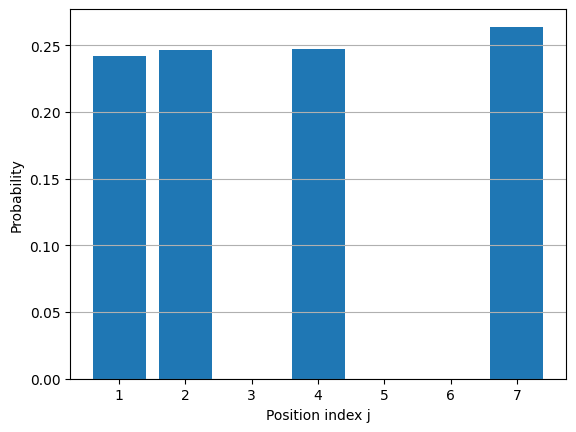

In [39]:
def plot_qrw_position_distribution(counts, title=None):
    """
    Aggregate counts over position index j and plot a bar chart.
    Assumes bitstring -> j via int(bitstring, 2), same as pricing code.
    """
    # Aggregate counts by j
    dist = {}
    total = 0
    for bitstring, c in counts.items():
        j = int(bitstring, 2)
        dist[j] = dist.get(j, 0) + c
        total += c

    js = sorted(dist.keys())
    probs = [dist[j] / total for j in js]

    plt.figure()
    plt.bar(js, probs)
    plt.xlabel("Position index j")
    plt.ylabel("Probability")
    if title is not None:
        plt.title(title)
    plt.grid(True, axis="y")
    plt.show()
plot_qrw_position_distribution(counts)

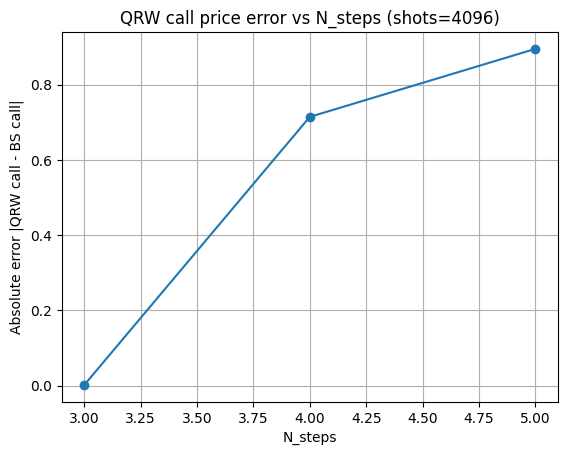

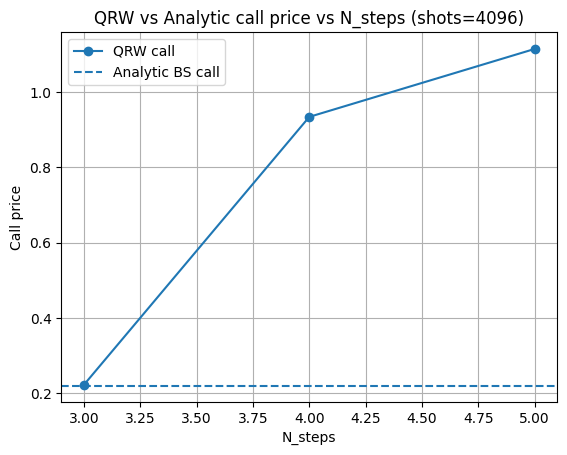

In [43]:
def collect_qrw_errors_vs_steps(Ns, shots=4096):
    """
    For a list of N_steps values, compute QRW call price and error vs analytic.
    Returns arrays (Ns_list, qrw_calls, errors).
    """
    global N_steps, delta_t, u, d, p_rn

    bs_c = bs_call_price(S0, K, r, sigma, T)

    Ns_list = []
    qrw_calls = []
    errors = []

    for N in Ns:
        N_steps = N
        delta_t = T / N_steps
        u = np.exp(sigma * np.sqrt(delta_t))
        d = np.exp(-sigma * np.sqrt(delta_t))
        p_rn = (np.exp(r * delta_t) - d) / (u - d)

        qrw_c, _, _ = qrw_call_put_price(shots=shots)
        err = abs(qrw_c - bs_c)

        Ns_list.append(N)
        qrw_calls.append(qrw_c)
        errors.append(err)

    return np.array(Ns_list), np.array(qrw_calls), np.array(errors)


def plot_error_vs_N_steps(Ns, shots=4096):
    Ns_arr, qrw_calls, errs = collect_qrw_errors_vs_steps(Ns, shots=shots)
    bs_c = bs_call_price(S0, K, r, sigma, T)

    plt.figure()
    plt.plot(Ns_arr, errs, marker="o")
    plt.xlabel("N_steps")
    plt.ylabel("Absolute error |QRW call - BS call|")
    plt.title(f"QRW call price error vs N_steps (shots={shots})")
    plt.grid(True)
    plt.show()

    # Optionally also plot prices themselves
    plt.figure()
    plt.plot(Ns_arr, qrw_calls, marker="o", label="QRW call")
    plt.axhline(bs_c, linestyle="--", label="Analytic BS call")
    plt.xlabel("N_steps")
    plt.ylabel("Call price")
    plt.title(f"QRW vs Analytic call price vs N_steps (shots={shots})")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_error_vs_N_steps([3, 4, 5], shots=4096)

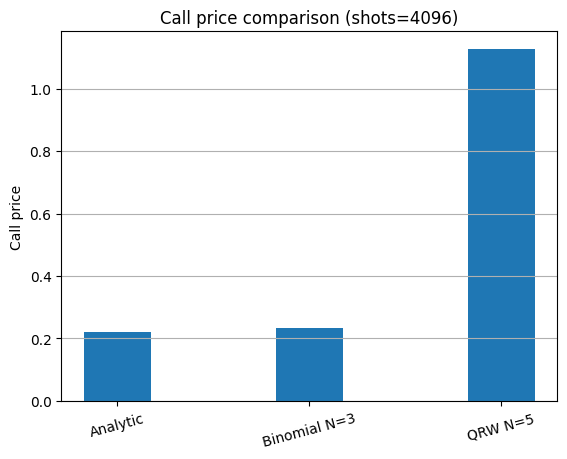

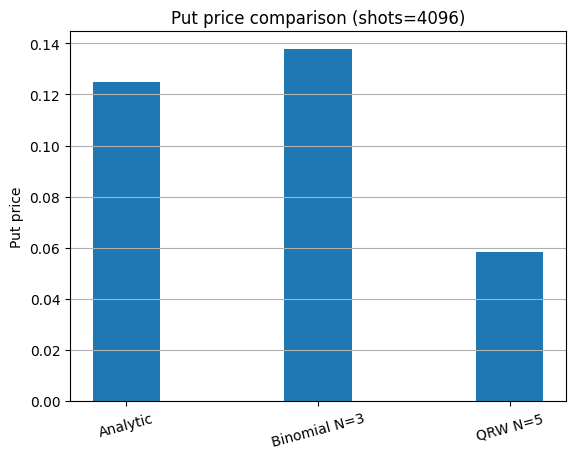

In [48]:
def plot_method_comparison(N_steps_for_binomial=5, shots_qrw=4096):
    """
    Compare Analytic BS, Binomial, and QRW prices in a single bar chart.
    Uses current global S0, K, r, sigma, T.
    """
    # Analytic
    bs_c = bs_call_price(S0, K, r, sigma, T)
    bs_p = bs_put_price(S0, K, r, sigma, T)

    # Binomial with chosen N_steps
    bin_c = binomial_call_price(S0, K, r, sigma, T, N_steps_for_binomial)
    bin_p = binomial_put_price(S0, K, r, sigma, T, N_steps_for_binomial)

    # QRW with N_steps currently in global scope
    qrw_c, qrw_p, _ = qrw_call_put_price(shots=shots_qrw)

    labels = ["Analytic", f"Binomial N={N_steps_for_binomial}", f"QRW N={N_steps}"]
    call_vals = [bs_c, bin_c, qrw_c]
    put_vals = [bs_p, bin_p, qrw_p]

    x = np.arange(len(labels))
    width = 0.35

    # Call prices
    plt.figure()
    plt.bar(x, call_vals, width)
    plt.xticks(x, labels, rotation=15)
    plt.ylabel("Call price")
    plt.title(f"Call price comparison (shots={shots_qrw})")
    plt.grid(True, axis="y")
    plt.show()

    # Put prices
    plt.figure()
    plt.bar(x, put_vals, width)
    plt.xticks(x, labels, rotation=15)
    plt.ylabel("Put price")
    plt.title(f"Put price comparison (shots={shots_qrw})")
    plt.grid(True, axis="y")
    plt.show()
plot_method_comparison(N_steps_for_binomial=3, shots_qrw=4096)